Loading Children's Data (Analyzing Diarrhea in the East)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_3903/3998143510.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = pd.to_numeric(df['v005'], errors='coerce') / 1000000.0



--- Summary: Child Diarrhea Prevalence (%) ---
           Prevalence
Location             
Rwamagana           5
Nyagatare          15
Gatsibo             5
Kayonza            15
Kirehe             15
Ngoma               5
Bugesera           17
East               11
Rwanda             14

✅ JSON saved: eastern_Child_Diarrhea_Prevalence.json
📊 Plot saved: Child_Diarrhea_Final_Ordered.png


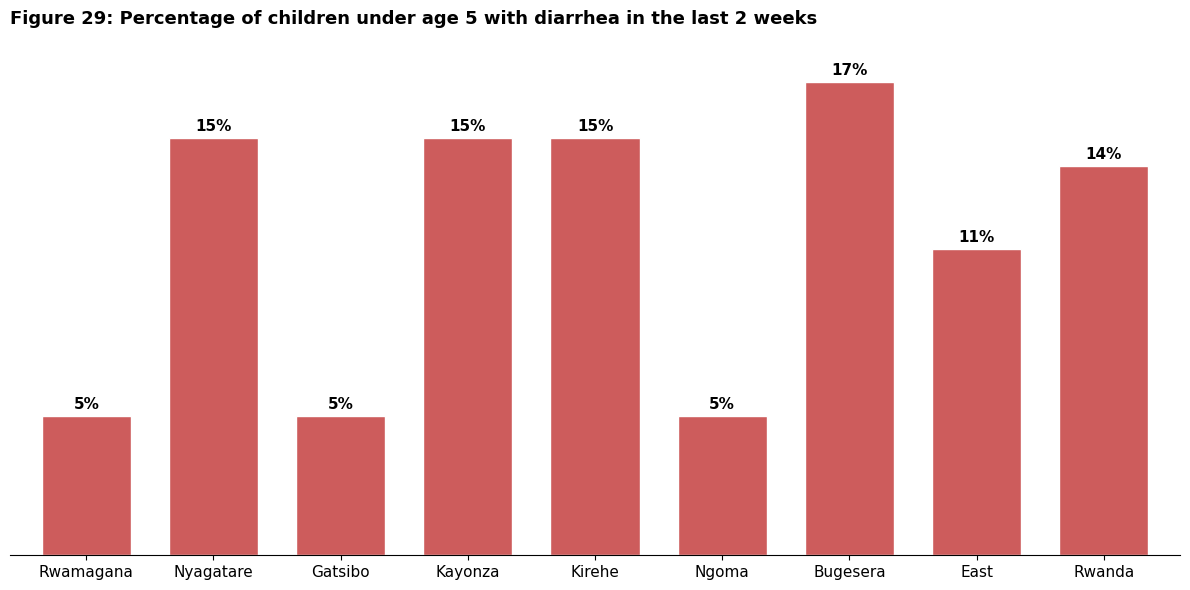

In [2]:
#!/usr/bin/env python3
# dhs_eastern_child_diarrhea_ordered_json.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS & MAPPING
# ------------------------------------------------------------------
FILE_PATH = os.path.join("data", "RWKR81FL.DTA")

# Mapping strata codes 47-60 to Eastern Province Districts
EASTERN_MAP = {
    47: "Rwamagana", 48: "Rwamagana",
    49: "Nyagatare", 50: "Nyagatare",
    51: "Gatsibo",   52: "Gatsibo",
    53: "Kayonza",   54: "Kayonza",
    55: "Kirehe",    56: "Kirehe",
    57: "Ngoma",     58: "Ngoma",
    59: "Bugesera",  60: "Bugesera"
}

# The specific requested order for display
DISTRICT_ORDER = [
    "Rwamagana", "Nyagatare", "Gatsibo", "Kayonza", 
    "Kirehe", "Ngoma", "Bugesera"
]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 and up to the next integer."""
    return int(math.floor(n + 0.5))

def get_weighted_pct(df, col_name):
    """Calculates weighted percentage as a rounded integer."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    val = np.average(df[col_name], weights=df['w']) * 100
    return standard_round(val)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Children's Data (Analyzing Diarrhea in the East)...")
    # Load and clean headers
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # Apply Weights
    df['w'] = pd.to_numeric(df['v005'], errors='coerce') / 1000000.0
    
    # --- FILTERS ---
    # 1. Living Children (b5=1)
    # 2. Under 5 years (b19 < 60 months)
    df = df[(df['b5'] == 1) & (df['b19'] < 60)].copy()

    # --- INDICATOR LOGIC ---
    # h11 codes: 1=Yes last 2 weeks, 2=Yes last 24h.
    df['has_diarrhea'] = df['h11'].isin([1, 2]).astype(int)

    # Aggregation Setup
    df_eastern = df[df['v024'] == 5].copy()
    df_eastern['dist_name'] = df_eastern['v023'].map(EASTERN_MAP)

    results = []
    
    # Process in the specific requested order
    for name in DISTRICT_ORDER + ["East", "Rwanda"]:
        if name == "Rwanda":
            subset = df
        elif name == "East":
            subset = df_eastern
        else:
            subset = df_eastern[df_eastern['dist_name'] == name]
        
        if subset.empty:
            continue
            
        val = get_weighted_pct(subset, 'has_diarrhea')
        results.append({"Location": name, "Prevalence": val})

    # Create Final DataFrame
    final_df = pd.DataFrame(results).set_index("Location")

    print("\n--- Summary: Child Diarrhea Prevalence (%) ---")
    print(final_df)

    # --- JSON OUTPUT (Replacing CSV) ---
    json_filename = "eastern_Child_Diarrhea_Prevalence.json"
    output_dict = {
        "indicator": "Figure 29: Percentage of children under age 5 with diarrhea in the last 2 weeks",
        "unit": "Percentage (%)",
        "data": final_df["Prevalence"].to_dict()
    }
    with open(json_filename, "w") as f:
        json.dump(output_dict, f, indent=4)
    print(f"\n✅ JSON saved: {json_filename}")

    # --- PLOTTING ---
    bar_colors = ["#CD5C5C"] * len(DISTRICT_ORDER) + ["#1E90FF", "#2E8B57"]
    ax = final_df.plot(kind="bar", figsize=(12, 6), width=0.7, color=bar_colors, legend=False, edgecolor="white")
    
    plt.title("Figure 29: Percentage of children under age 5 with diarrhea in the last 2 weeks", 
              fontsize=13, fontweight="bold", loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ['top', 'right', 'left']: ax.spines[s].set_visible(False)

    # Add numeric labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Child_Diarrhea_Final_Ordered.png", dpi=300)
    print("📊 Plot saved: Child_Diarrhea_Final_Ordered.png")
    plt.show()